# `00` Problem Statement:

The goal is to estimate the direction in which the person is looking.  
This can be done using the orientation of the head.  
The orientation of the head can be defined in terms of pitch, roll, and yaw movements describing the three degrees of freedom of a human head.  

<center><img src="https://www.researchgate.net/profile/Tsang-Ing-Ren/publication/279291928/figure/fig1/AS:292533185462272@1446756754388/Orientation-of-the-head-in-terms-of-pitch-roll-and-yaw-movements-describing-the-three.png" alt="Head Pose angles"></center>

In [1]:
%%capture
!pip install mediapipe

# `01` Loading Required Libraries:

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy
from math import cos, sin
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading AFLW2000 Data
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


# `02` Exploring ALFW2000 Dataset:

Num of images:  2000
Image shape:  (450, 450, 3)


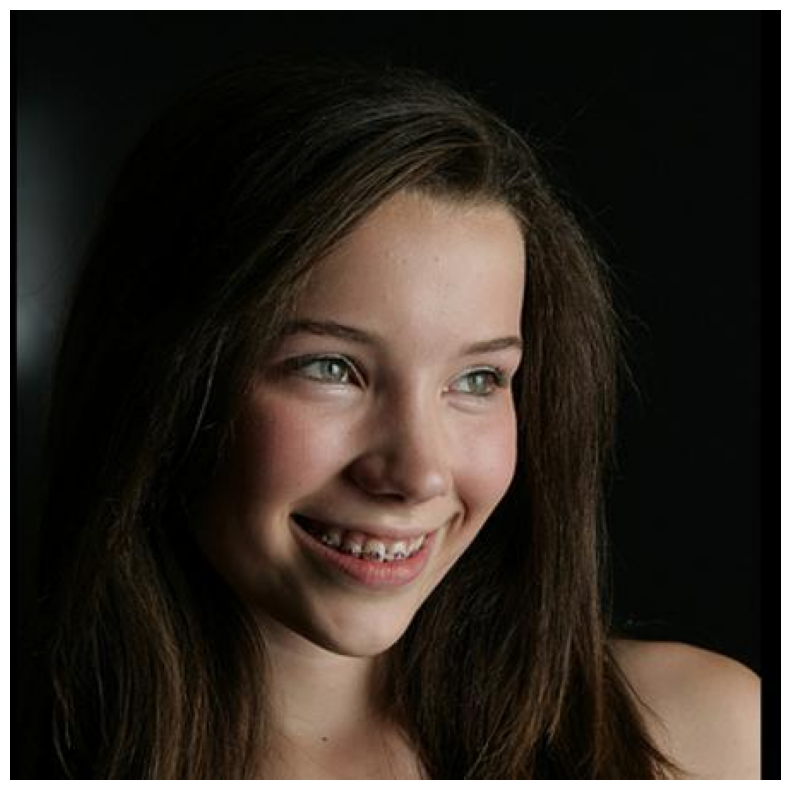

In [4]:
DEMO_IMG_NUMBER = 805
images_paths = glob.glob('./AFLW2000/*.jpg')
print('Num of images: ', len(images_paths))
img = cv2.imread(images_paths[DEMO_IMG_NUMBER])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img);

In [5]:
img_info_paths = glob.glob('./AFLW2000/*.mat') #this line returns list of path to matlab files
mat = scipy.io.loadmat(img_info_paths[DEMO_IMG_NUMBER])
mat['Pose_Para'][0][:3]                 #Extracting pitch, yaw, and roll

array([-0.31531143, -0.33785677,  0.1856054 ], dtype=float32)

We can use mediapipe's mesh grid to find the landmarks of the face, which can be used as input to our model to estimate the rotation angles.  
and we can use landmark $1$ that defines the nose, which can be used as the origin point in our system and we will translate our axes to that new origin.

i=0
nose position:  (244.2385733127594, 283.98174941539764)


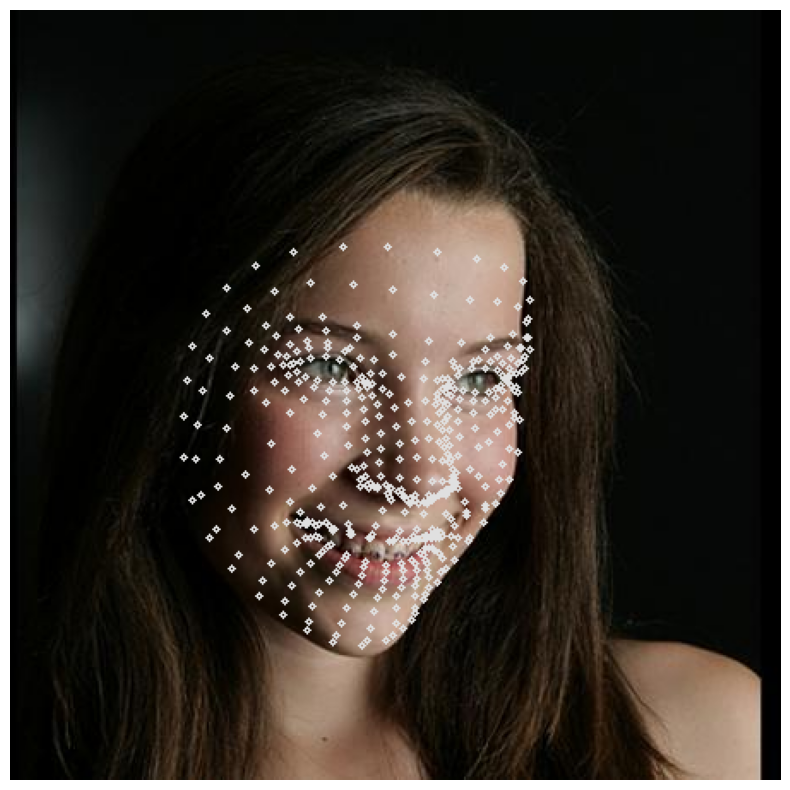

In [6]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) #initializing face_mesh model from mediapipe library

drawing_specs = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1)

result = face_mesh.process(img) #This line processes the input (img) using the (face_mesh). It detects facial landmarks in the image and returns the result.

img_h, img_w, img_c = img.shape
annot_img = img.copy()
i=0
if result.multi_face_landmarks != None:
    for face_landmarks in result.multi_face_landmarks: #iterate over each face found
        print(f"i={i}")
        mp.solutions.drawing_utils.draw_landmarks(image=annot_img, landmark_list=face_landmarks, landmark_drawing_spec=drawing_specs)
        for idx, lm in enumerate(result.multi_face_landmarks[0].landmark):
            if idx == 1:
                nose_x = lm.x * img_w
                nose_y = lm.y * img_h

print('nose position: ', (nose_x, nose_y))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(annot_img)

We can look at the axes rotation in 2 similar ways:  
1- Keeping the original axes as they are and rotating the object around them using the pitch, roll, and yaw  
2- Rotating the axes themselves, while keeping the object in a fixed position with respect to the axes, this is called Euler rotation.  

Euler rotation can be defined in 3 successive steps:  
1- Rotation around the $x$ axis with angle $\gamma$ -> same as pitch  
2- Rotation around the new $y$ axis with angle $\beta$ -> same as yaw  
3- Rotation around the new $z$ axis with angle $\alpha$ -> same as roll  

So we first define our original axes, which is the identity matrix, we then rotate them using the euler rotation, then we project the new axes point to the 2D space of the image using the simplest form of projection (orthogonal projection which works by just dropping the z-axis), finally we translate the new axes to the nose position.

In [7]:
def draw_axes(img, pitch,yaw,roll, tdx=None, tdy=None, size = 50):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

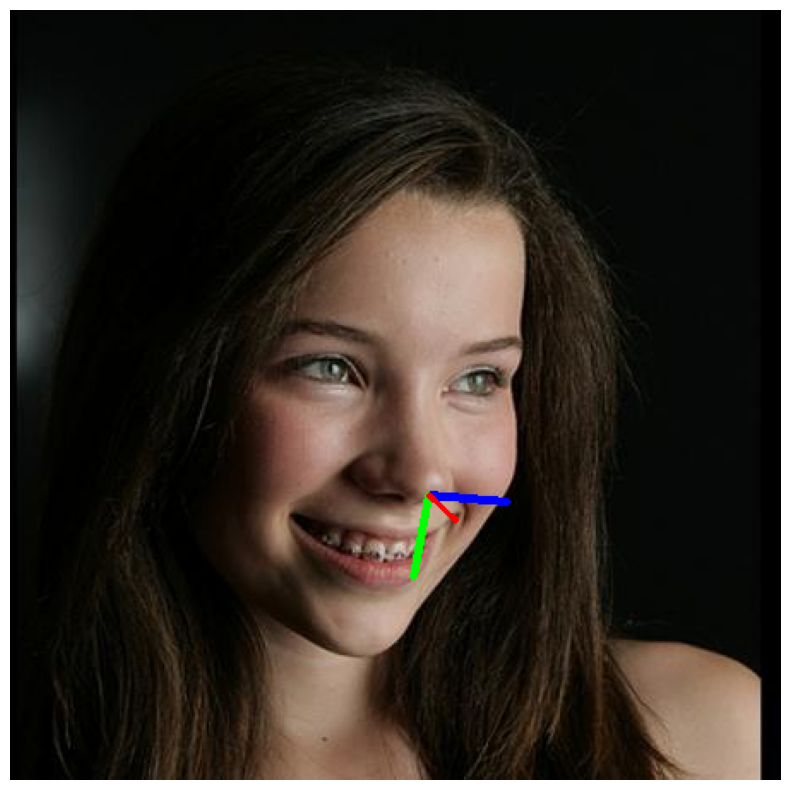

In [8]:
pitch, yaw, roll = mat['Pose_Para'][0][:3]
new_img = draw_axes(img, pitch, yaw, roll, nose_x, nose_y)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(new_img);

# `03` Feature Extraction:

As most of the points in the face mesh are close to each other and don't offer new information.  
I will use some of the main points of the face mesh grid as the features, and use them to estimate the value of the rotation angles: pitch, yaw, and roll.

In [9]:
def extract_features(img, face_mesh, mat=None):
    NOSE = 1
    FOREHEAD = 10
    LEFT_EYE = 33
    MOUTH_LEFT = 61
    CHIN = 199
    RIGHT_EYE = 263
    MOUTH_RIGHT = 291


    result = face_mesh.process(img)
    face_features = []

    if result.multi_face_landmarks != None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in [FOREHEAD, NOSE, MOUTH_LEFT, MOUTH_RIGHT, CHIN, LEFT_EYE, RIGHT_EYE]:
                    face_features.append(lm.x)
                    face_features.append(lm.y)
    else:
        face_features.extend([None] * 14)

    if mat:
        pose_angles = mat['Pose_Para'][0][:3]
        face_features.extend(pose_angles)

    return face_features

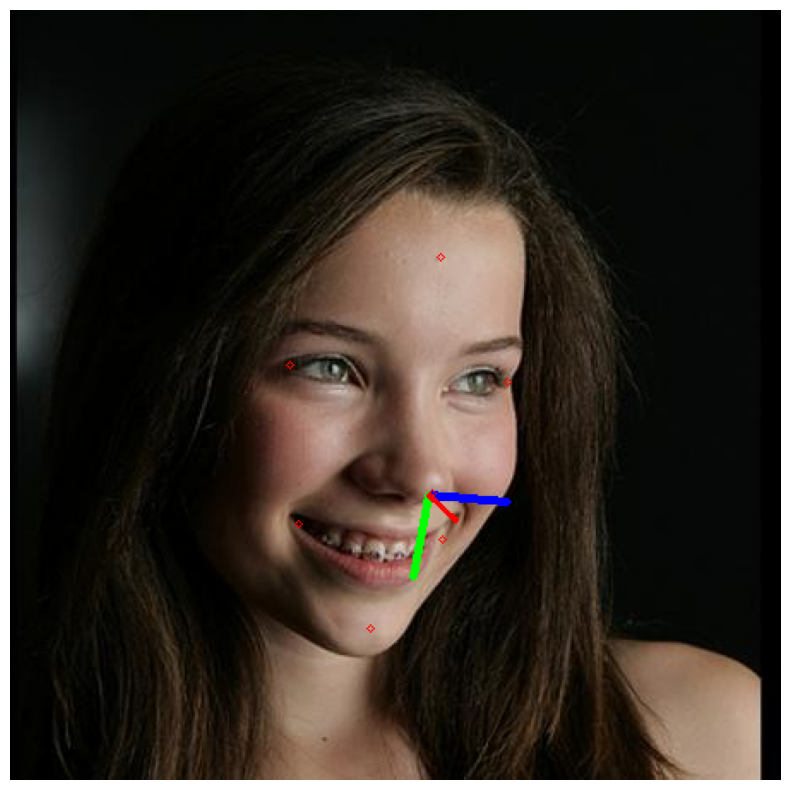

In [10]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
s = extract_features(img, face_mesh)
annot_img = img.copy()

for i in range(len(s)//2):
        cv2.circle(annot_img, center=[int(s[i*2]*img_w), int(s[i*2+1]*img_h)], radius=2, color=(255, 0, 0))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(annot_img);


# `04` Saving Data to csv File:

In [11]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)
cols.extend(['pitch', 'yaw', 'roll'])

In [12]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
poses = []

for img_idx, img_path in enumerate(images_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mat = scipy.io.loadmat(img_info_paths[img_idx])
    face_features = extract_features(img, face_mesh, mat)
    poses.append(face_features)
    if img_idx % 100 == 0:
        print('Extracted images: ', img_idx)

poses_df = pd.DataFrame(poses, columns=cols)

Extracted images:  0
Extracted images:  100
Extracted images:  200
Extracted images:  300
Extracted images:  400
Extracted images:  500
Extracted images:  600
Extracted images:  700
Extracted images:  800
Extracted images:  900
Extracted images:  1000
Extracted images:  1100
Extracted images:  1200
Extracted images:  1300
Extracted images:  1400
Extracted images:  1500
Extracted images:  1600
Extracted images:  1700
Extracted images:  1800
Extracted images:  1900


In [13]:
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.486602,0.624109,0.522991,0.301004,0.354324,0.441646,0.412282,0.681156,0.483026,0.786989,0.680817,0.491351,0.567541,0.702234,-0.197102,-0.070430,0.105118
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.232617,-1.418751,0.175960
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.447955,1.431267,-1.509418
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.420465,-1.191176,0.451515


In [14]:
poses_df.to_csv('./poses.csv', index=False)

In [15]:
poses_df = pd.read_csv('./poses.csv')
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.486602,0.624109,0.522991,0.301004,0.354324,0.441646,0.412282,0.681156,0.483026,0.786989,0.680817,0.491351,0.567541,0.702234,-0.197102,-0.070430,0.105118
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.232617,-1.418751,0.175960
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.447955,1.431267,-1.509418
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.420465,-1.191176,0.451515


In [16]:
poses_df.isna().sum()

nose_x           208
nose_y           208
forehead_x       208
forehead_y       208
left_eye_x       208
left_eye_y       208
mouth_left_x     208
mouth_left_y     208
chin_x           208
chin_y           208
right_eye_x      208
right_eye_y      208
mouth_right_x    208
mouth_right_y    208
pitch              0
yaw                0
roll               0
dtype: int64

In [17]:
poses_df = poses_df.dropna(axis=0)

In [18]:
poses_df.isna().sum()

nose_x           0
nose_y           0
forehead_x       0
forehead_y       0
left_eye_x       0
left_eye_y       0
mouth_left_x     0
mouth_left_y     0
chin_x           0
chin_y           0
right_eye_x      0
right_eye_y      0
mouth_right_x    0
mouth_right_y    0
pitch            0
yaw              0
roll             0
dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(poses_df, test_size=0.2, random_state=42)


X_train = train_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_train = train_df[['pitch', 'yaw', 'roll']]

X_val = val_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_val = val_df[['pitch', 'yaw', 'roll']]
print(X_train.shape, y_train.shape)

(1433, 14) (1433, 3)


In [20]:
print(X_val.shape, y_val.shape)

(359, 14) (359, 3)


In [21]:
def normalize(poses_df):
    normalized_df = poses_df.copy()

    for dim in ['x', 'y']:
        # Centerning around the nose
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = poses_df[feature] - poses_df['nose_'+dim]


        # Scaling
        diff = normalized_df['mouth_right_'+dim] - normalized_df['left_eye_'+dim]
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = normalized_df[feature] / diff

    return normalized_df

In [22]:
X_train = normalize(X_train)
X_val=normalize(X_val)


In [23]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from sklearn.metrics import mean_squared_error

param_grid = {
    'estimator__kernel': ['linear', 'poly', 'rbf'],
    'estimator__C': scipy.stats.expon(scale=5),
    'estimator__degree': np.arange(2, 6),
    'estimator__coef0': np.arange(0, 6),
    'estimator__gamma': scipy.stats.expon(scale=.1),
    'estimator__epsilon': scipy.stats.expon(scale=.1)
}

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
random_search = RandomizedSearchCV(multi_out_svr, param_grid, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
svr_model = random_search.best_estimator_
print('best parameters: ', random_search.best_params_)
print('train_rmse: ', np.sqrt(-random_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, svr_model.predict(X_val))))

best parameters:  {'estimator__C': 2.3463404498842957, 'estimator__coef0': 4, 'estimator__degree': 4, 'estimator__epsilon': 0.13167456935454494, 'estimator__gamma': 0.09129425537759533, 'estimator__kernel': 'rbf'}
train_rmse:  0.22580119825259917
validation_rmse:  0.1884249528604136


In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'estimator__max_depth': np.arange(2, 10),
    'estimator__min_samples_split': np.logspace(1, 7, 7, base=2).astype(int),
    'estimator__min_samples_leaf': np.logspace(0, 6, 7, base=2).astype(int),
    'estimator__max_features': np.arange(4, 15),
    'estimator__ccp_alpha': scipy.stats.expon(scale=.1),
}

reg_tree = DecisionTreeRegressor(random_state=42)
multi_out_tree = MultiOutputRegressor(reg_tree)

random_search = RandomizedSearchCV(multi_out_tree, param_grid, scoring='neg_mean_squared_error', n_iter=40)
random_search.fit(X_train, y_train)
tree_model = random_search.best_estimator_

print('best parameters: ', random_search.best_params_)
print('train_rmse: ', np.sqrt(-random_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, tree_model.predict(X_val))))

best parameters:  {'estimator__ccp_alpha': 0.0066558901530282474, 'estimator__max_depth': 7, 'estimator__max_features': 11, 'estimator__min_samples_leaf': 64, 'estimator__min_samples_split': 16}
train_rmse:  0.2711479688207571
validation_rmse:  0.23639105977796043


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import scipy.stats
import numpy as np

param_grid = {
    'estimator__fit_intercept': [True, False],
}

lr = LinearRegression()
multi_out_lr = MultiOutputRegressor(lr)
random_search = RandomizedSearchCV(multi_out_lr, param_grid, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
lr_model = random_search.best_estimator_

print('best parameters: ', random_search.best_params_)
print('train_rmse: ', np.sqrt(-random_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, lr_model.predict(X_val))))


best parameters:  {'estimator__fit_intercept': True}
train_rmse:  2.633286281007989
validation_rmse:  0.3360165272518735


Image shape:  (450, 450, 3)
targets:  [-0.15810244  0.34346703 -0.3815295 ]


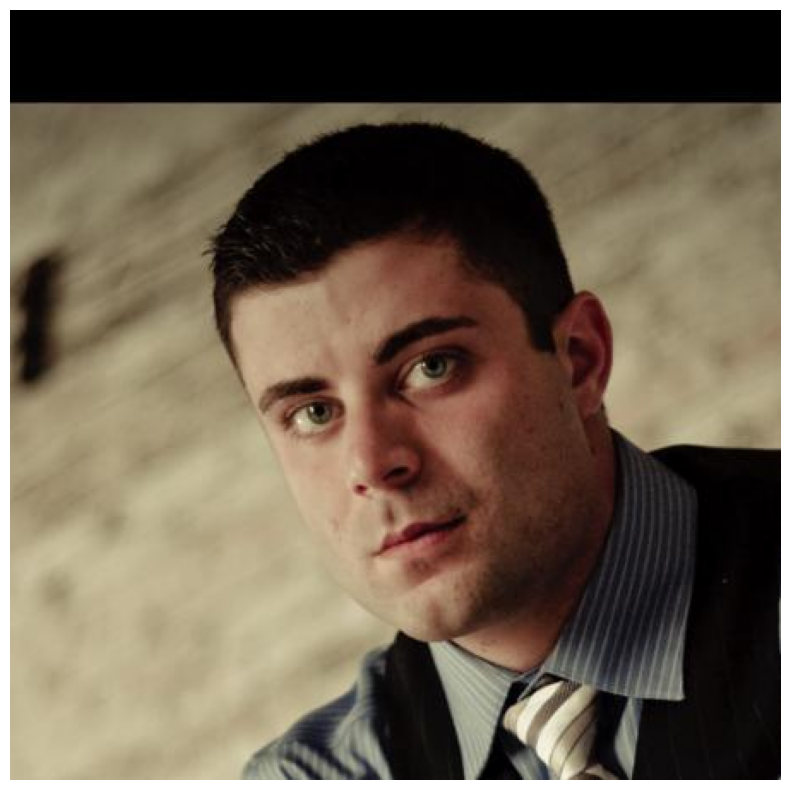

In [26]:
DEMO_IMG_NUMBER = 11
images_paths = glob.glob('./AFLW2000/*.jpg')
img = cv2.imread(images_paths[DEMO_IMG_NUMBER])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img);

img_info_paths = glob.glob('./AFLW2000/*.mat')
mat = scipy.io.loadmat(img_info_paths[DEMO_IMG_NUMBER])
print('targets: ', mat['Pose_Para'][0][:3].ravel())                 #Extracting Pitch, Yaw, and Roll

In [27]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)

In [28]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
face_features = extract_features(img, face_mesh)
face_features_df = pd.DataFrame([face_features], columns=cols)
face_features_normalized = normalize(face_features_df)
pitch_pred, yaw_pred, roll_pred = tree_model.predict(face_features_normalized).ravel()
print('predictions: ', pitch_pred, yaw_pred, roll_pred)

predictions:  0.14793824190972374 0.4459348410941738 -0.24929760905308057


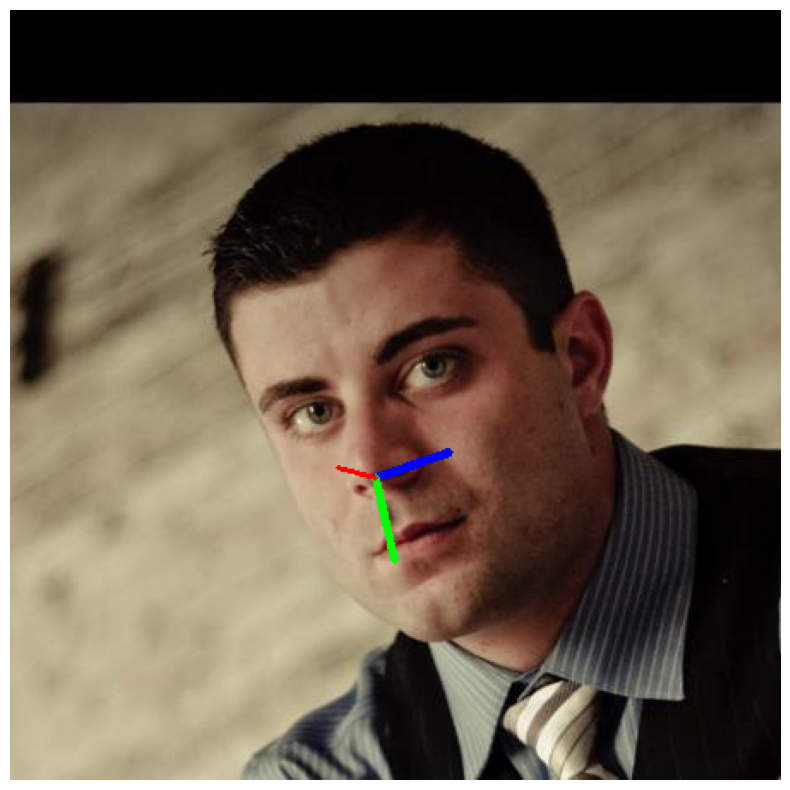

In [29]:
img_h, img_w, img_c = img.shape
nose_x = face_features_df['nose_x'].values * img_w
nose_y = face_features_df['nose_y'].values * img_h

new_img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(new_img);

In [30]:
print("we are here0")
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

input_video_path = 'D:\test_vid.mp4'
cap = cv2.VideoCapture(input_video_path)

output_video_path = 'D:\new_folder'
fps = cap.get(cv2.CAP_PROP_FPS)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

frame_count = 0
processing_interval = 1
print("we are here 1")
while(cap.isOpened()):

#     # Take each frame
    ret, img = cap.read()
    if ret:
        if frame_count % processing_interval == 0:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.flip(img, 1)
            img_h, img_w, img_c = img.shape
            text = ''
#         print(img.shape)
        
            face_features = extract_features(img, face_mesh)
        frame_count =frame_count + 1
        print(f"{len(face_features)}")
        if len(face_features):
            face_features_df = pd.DataFrame([face_features], columns=cols)
            face_features_normalized = normalize(face_features_df)
            pitch_pred, yaw_pred, roll_pred = svr_model.predict(face_features_normalized).ravel()
            nose_x = face_features_df['nose_x'].values * img_w
            nose_y = face_features_df['nose_y'].values * img_h
            img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
                        
            if pitch_pred > 0.3:
                text = 'Top'
                if yaw_pred > 0.3:
                    text = 'Top Left'
                elif yaw_pred < -0.3:
                    text = 'Top Right'
            elif pitch_pred < -0.3:
                text = 'Bottom'
                if yaw_pred > 0.3:
                    text = 'Bottom Left'
                elif yaw_pred < -0.3:
                    text = 'Bottom Right'
            elif yaw_pred > 0.3:
                text = 'Left'
            elif yaw_pred < -0.3:
                text = 'Right'
            else:
                text = 'Forward'
                
        cv2.putText(img, text, (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imshow('img', img)
        k = cv2.waitKey(1) & 0xFF
        if k == ord("q"):
            break
        out.write(img)
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

we are here0
we are here 1


In [31]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture(0)  # From Camera

while(cap.isOpened()):

    # Take each frame
    ret, img = cap.read()
    if ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.flip(img, 1)
        img_h, img_w, img_c = img.shape
        text = ''
        
        
        face_features = extract_features(img, face_mesh)
        if len(face_features):
            face_features_df = pd.DataFrame([face_features], columns=cols)
            face_features_normalized = normalize(face_features_df)
            pitch_pred, yaw_pred, roll_pred = svr_model.predict(face_features_normalized).ravel()
            nose_x = face_features_df['nose_x'].values * img_w
            nose_y = face_features_df['nose_y'].values * img_h
            img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
                        
            if pitch_pred > 0.3:
                text = 'Top'
                if yaw_pred > 0.3:
                    text = 'Top Left'
                elif yaw_pred < -0.3:
                    text = 'Top Right'
            elif pitch_pred < -0.3:
                text = 'Bottom'
                if yaw_pred > 0.3:
                    text = 'Bottom Left'
                elif yaw_pred < -0.3:
                    text = 'Bottom Right'
            elif yaw_pred > 0.3:
                text = 'Left'
            elif yaw_pred < -0.3:
                text = 'Right'
            else:
                text = 'Forward'
                
        cv2.putText(img, text, (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imshow('img', img)
        k = cv2.waitKey(1) & 0xFF
        if k == ord("q"):
            break
    else:
        break

cv2.destroyAllWindows()
cap.release()